In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [3]:
dfi = pd.read_csv('./kaggle/city_hour.csv')
dfi

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [4]:
dfi.dropna()
df = dfi.loc[ dfi['City'] == 'Delhi']  #will be using the delhi data first for simplicity
df = df.loc[df['Datetime'] < '2016-01-01 00:00:00']
df = df.dropna()

In [5]:
df = df.reset_index()
df = df.drop(['index','City','AQI_Bucket','Datetime','SO2', 'O3','Benzene','Toluene','Xylene','NO','NOx','NH3','NO2'], axis=1)
df

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
4944,142.61,359.15,2.64,412.0
4945,201.88,464.06,3.79,415.0
4946,272.73,535.32,2.89,432.0
4947,271.46,518.95,3.02,433.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949 entries, 0 to 4948
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   4949 non-null   float64
 1   PM10    4949 non-null   float64
 2   CO      4949 non-null   float64
 3   AQI     4949 non-null   float64
dtypes: float64(4)
memory usage: 154.8 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
3954,181.59,378.51,2.88,437.0
3955,183.38,347.46,2.49,432.0
3956,170.97,276.65,2.07,424.0
3957,160.19,243.97,1.56,414.0


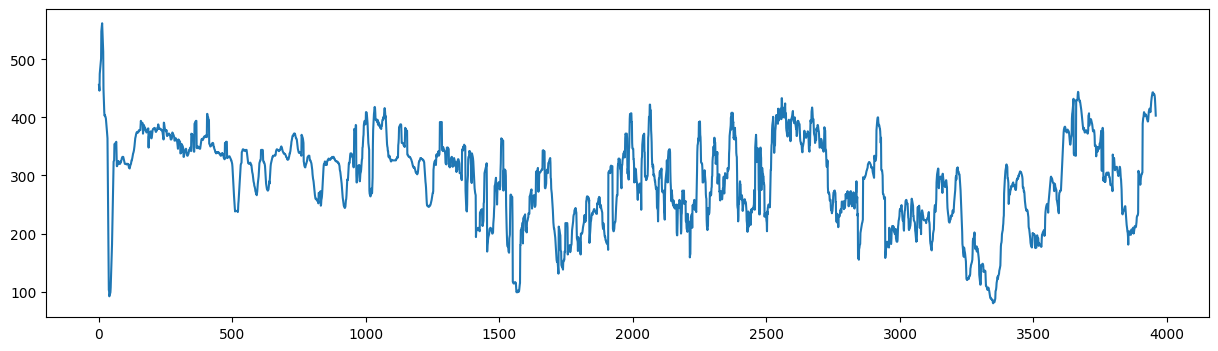

In [8]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["AQI"])
plt.show()

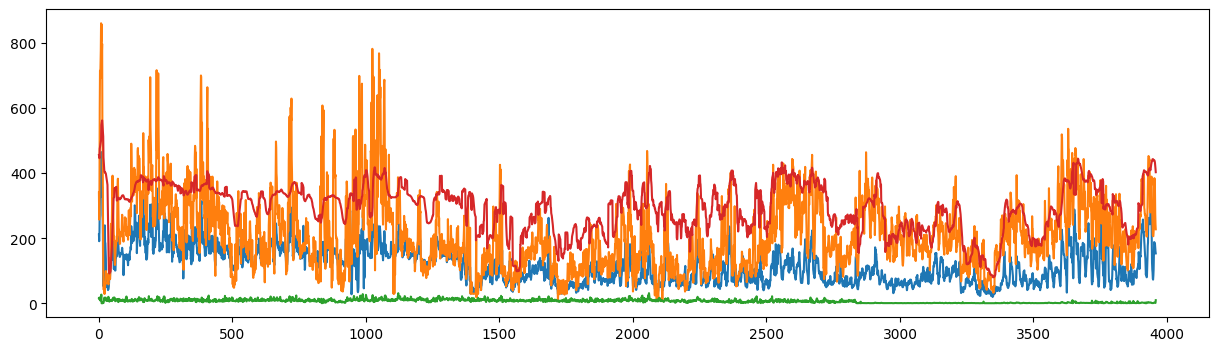

In [9]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [10]:
df['tmrw_aqi'] = df['AQI'].shift(-1)
#df['tmrw_aqi']  = df['AQI'].ffill(limit=200)
df['tmrw_aqi'][len(df)-1] = df['tmrw_aqi'][len(df)-2]

In [11]:
df

,PM2.5,PM10,CO,AQI,tmrw_aqi
0,211.51,340.66,15.24,456.0,450.0
1,191.12,257.40,13.11,450.0,446.0
2,218.44,351.01,18.35,446.0,475.0
3,296.80,600.95,16.67,475.0,480.0
4,336.43,714.63,12.17,480.0,484.0
...,...,...,...,...,...
4944,142.61,359.15,2.64,412.0,415.0
4945,201.88,464.06,3.79,415.0,432.0
4946,272.73,535.32,2.89,432.0,433.0
4947,271.46,518.95,3.02,433.0,435.0


In [12]:

x = df.iloc[:, :4].values
y = df.iloc[:, 4].values

In [13]:
split = int(df.shape[0]* 0.8)


train_x, test_x = x[:split, :], x[split:, :]
train_y, test_y = y[:split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (3959, 4) trainY: (3959,)
testX: (990, 4) testY: (990,)


In [14]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

In [15]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i - window: i+1]#i - window: i + 1
        x_.append(tmp_x)
        y_.append(tmp_y)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    return x_, y_

In [16]:
train_x_slide, train_y_slide = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} ')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape}')

train_x: torch.Size([3956, 3, 4]) train_y: torch.Size([3956, 4, 1]) 
test_x: torch.Size([987, 3, 4]) test_y: torch.Size([987, 4, 1])


In [17]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)    
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [18]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, Aer
from qiskit.visualization import *
#from qiskit.opflow import StateFn, PauliSumOp, ListOp, AerPauliExpectation
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector, SparsePauliOp, PauliList
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from typing import Optional
from qiskit_aer import AerSimulator



qr = QuantumRegister(2*qubits)
reg_d = qr[0:qubits] # reg_d for the time series and reg_h for memory
reg_h = qr[qubits:2*qubits]
cr = ClassicalRegister(qubits)
qc = QuantumCircuit(qr, cr)
qc2 = QuantumCircuit(qr, cr)

In [19]:
encoded_angle = np.arctan([1.7163, 1.1380, 1.5963, 2.1931])
for i in range(qubits):
        qc.rx(encoded_angle[i], qr[i])

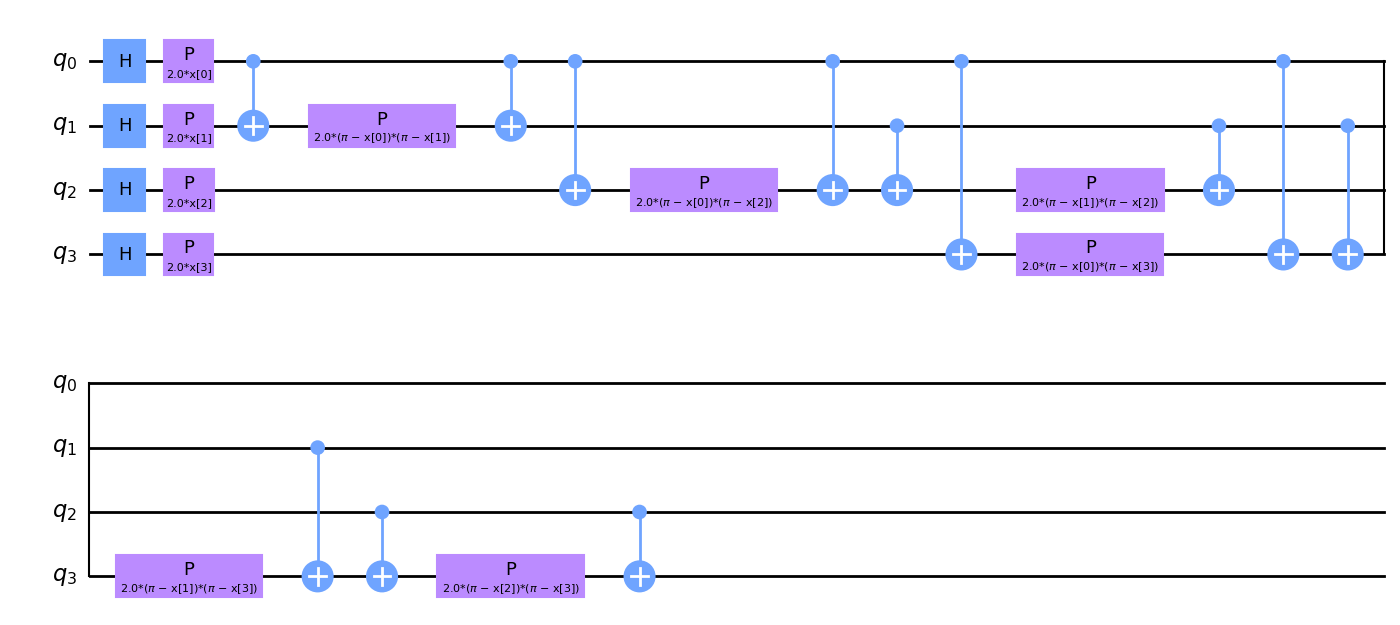

In [20]:
from qiskit.circuit.library import ZZFeatureMap

num_features = train_x_slide.shape[2]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

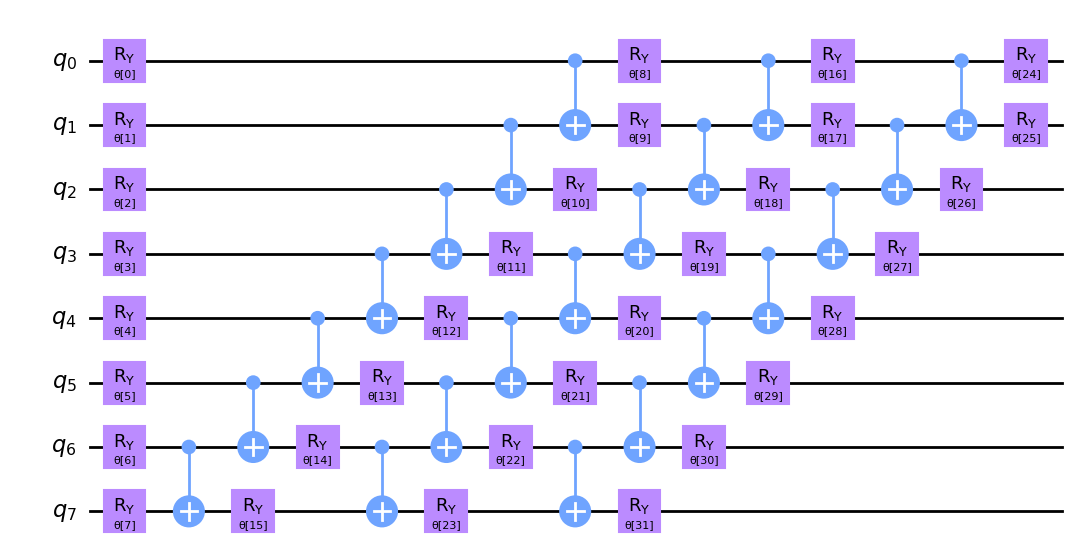

In [21]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2*qubits, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

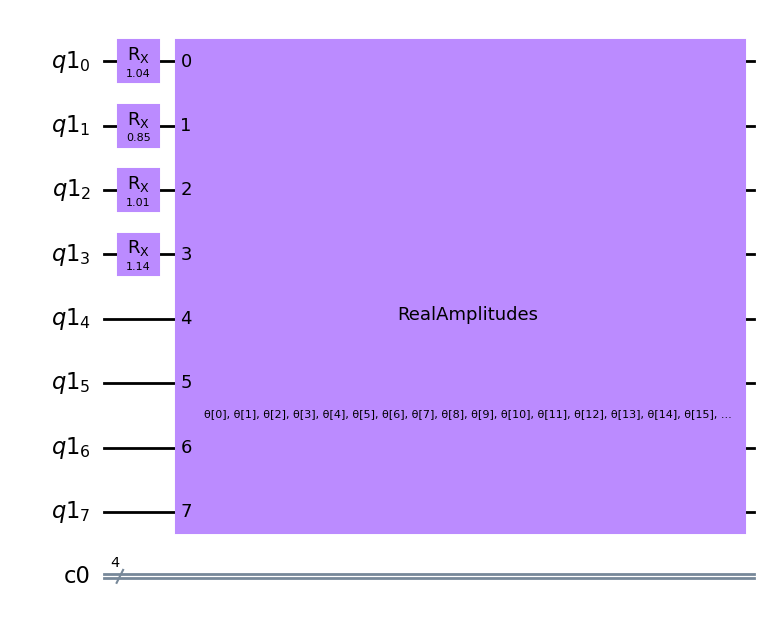

In [22]:
#qc.compose(feature_map,inplace=True)
qc.compose(ansatz,inplace=True)

qc.draw(output="mpl", style="clifford", fold=20)

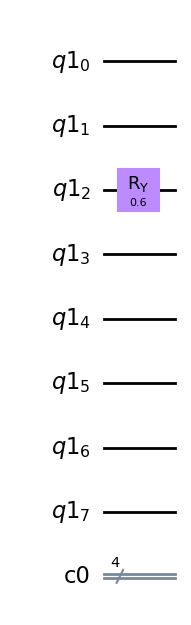

In [23]:
qc2.ry(0.6,qr[2])
qc2.draw(output="mpl", style="clifford", fold=20)

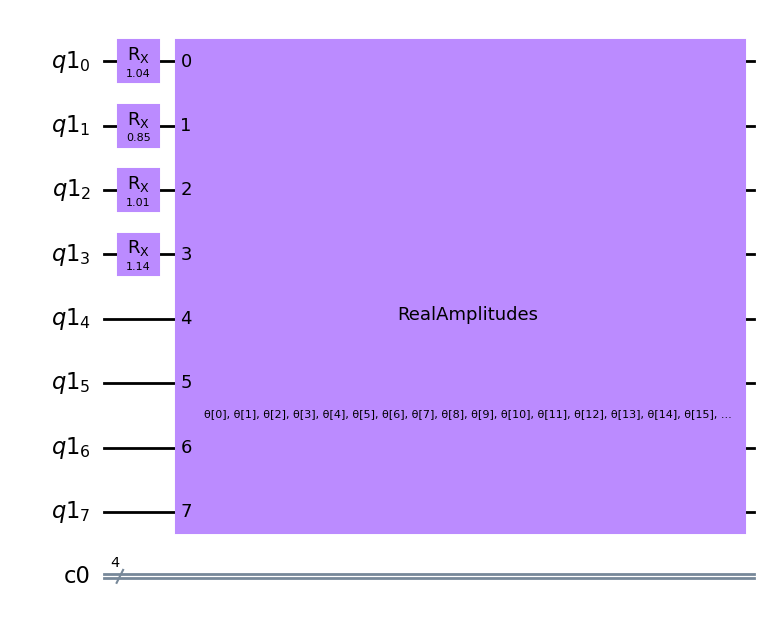

In [24]:
qc.draw(output="mpl", style="clifford", fold=20)

In [25]:
class QLSTM():
    def __init__(self,
                backend,
                input_size: int, 
                hidden_size: int, 
                n_qubits: int = 4,
                n_layers: int = 1,
                batch_first: Optional[bool] = True,
                sample_instance: Sampler = None,
                feature_map: QuantumCircuit = None,
                ansatz: QuantumCircuit = None,
                n_qlayers=1,):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.batch_first = batch_first
        self.n_layers = n_layers # lagged data window size
        self._qlayers = {}
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"
        self.sample_instance = Sampler()
        #self.qr = QuantumRegister(2*self.n_qubits)
        self.qr = QuantumRegister(self.n_qubits)
        #self.reg_d = self.qr[0:self.n_qubits]
        #self.reg_h = self.qr[self.n_qubits:2*self.n_qubits]
        if feature_map:
            if feature_map.num_qubits == n_qubits:
                _feature_map = feature_map
            else:
                raise ValueError(f"Incompatible parameter n_qubits={n_qubits} with "f"feature_map of {feature_map.num_qubits} qubits")
        else:
            _feature_map = ZZFeatureMap(n_qubits)

        if ansatz:
            _ansatz = ansatz
        else:
            _ansatz = RealAmplitudes(n_qubits, entanglement='linear', reps=n_layers)
        
        

       
        self.clayer_in = nn.Linear(input_size + hidden_size, n_qubits)
        # quantum layers
        self._make_q_layers(_feature_map, _ansatz)

        self.clayer_out = nn.Linear(n_qubits, hidden_size)
      
    
    def _make_q_layers(self, feature_map, ansatz):
        for gate in ['forget', 'input', 'update', 'output']:
            n_inputs = feature_map.num_qubits
            qc = QuantumCircuit(n_inputs)
            qc.append(feature_map, range(n_inputs))
            qc.append(ansatz, range(n_inputs))

            #readout_op = PauliList([ ~Statevector(SparsePauliOp.from_list([('Z' * self.hidden_size, 1)])) @ Statevector(qc)] * n_inputs)

            input_params = list(feature_map.parameters)
            weight_params = list(ansatz.parameters)
            parity = lambda x: "{:b}".format(x).count("1") % 2

            layer = SamplerQNN(
                circuit=qc,
                input_params=input_params,
                weight_params=weight_params,
                sampler=self.sample_instance,
                interpret=parity,
                output_shape=4
            )

            initial_weights = Tensor(np.zeros(n_inputs * self.n_layers * 2))
            self._qlayers[gate] = TorchConnector(layer, initial_weights=initial_weights)

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self._qlayers['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self._qlayers['input'](y_t)))  # input block
            g_t = torch.sigmoid(self.clayer_out(self._qlayers['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self._qlayers['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [26]:
class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, backend, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        self.backend = backend
        
        self.lstm = QLSTM(
            backend = backend,
            input_size=num_sensors,
            hidden_size=hidden_units,
            n_qubits = n_qubits,
            n_layers= n_qlayers,
            batch_first=True
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm.forward(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [1]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
from qiskit_aer import Aer
batch_size = 4
learning_rate = 0.004
num_epochs = 5
from qiskit.providers.basic_provider import BasicProvider
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)
backend = Aer.get_backend("statevector_simulator")
modelQ = QRegressionLSTM(num_sensors=4, hidden_units= 5, backend = backend, n_qubits=4, n_qlayers = 1)
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

from qiskit_algorithms.optimizers import COBYLA

optimizerQ = COBYLA(maxiter=100)
#optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))
print(device)

NameError: name 'torch' is not defined

In [27]:
histQ = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_Q = []
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)
        #print(output)
        #print(y)
        
        
        d = y[:4, :].squeeze(2)
        #print(d[0])
        #output = torch.cat([d[0], output.reshape(-1, 1)], axis = 1)
        #label = torch.ones_like(y).to(device)
        #lossQ = criterion(output, label)
        
        lossQ = criterion(output, d[0])
        lossQ.backward()
        optimizerQ.step()
        loss_Q.append(lossQ.item()) 
    histQ[epoch] = sum(loss_Q)  
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{sum(loss_Q)}')

[1/5]  LossQ:2437.540145979263


KeyboardInterrupt: 